# Hack The Feed: Insights From Social Media Data

### 🎯 Project Brief

Playhouse Communication is one of Nigeria's leading digital marketing agencies. They combine design and media planning with cutting-edge tech solutions to reimagine what marketing is all about. Their client roster is a mix of global juggernauts and nimble SMEs, each redefining their sectors.

We are rolling out the ultimate arena for innovation in data and setting the stage for up and coming data scientists and analysts to showcase their skills, win huge cash prizes, and boost their careers. The "Hack the Feed" hackathon is a showdown where data analytics meets creative prowess.

Your mission? To decode a treasure trove of social media data for one of our high-profile clients and transform it into game-changing insights.

In a rare move, we're handing you the keys to a vault of exclusive social media data to let you dig deep, get creative, and strike gold with actionable insights that could redefine the future of digital marketing.  This isn't just a hackathon; it's your chance to shape the future of digital engagement. 🚀

Key Deliverables:
Participants are expected to:

    Create a comprehensive and reproducible report detailing their findings.
    Propose actionable recommendations based on the insights.
    Create a simple and engaging visualisation of your results & analysis.


Evaluation Criteria:
Submissions will be evaluated based on the following:

    Innovativeness:
        Originality and novelty of the insights.
    Actionability:
        Practicality and feasibility of the recommendations.
    Presentation Quality:
        Clarity and effectiveness in conveying findings in writing and visual form.
    Depth of Analysis:
        How thoroughly the data has been explored and understood.

In [24]:
import os
import gc
import shutil
import copy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import random
from collections import defaultdict
from typing import Union, List, Literal, Dict, Callable, Tuple, Optional
from tqdm import tqdm

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold, KFold

In [2]:
import nltk
from IPython.display import display
from nltk.tokenize import sent_tokenize
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from collections import Counter
nltk.download('stopwords')
nltk.download('vader_lexicon')

import string
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [3]:
data_dir = '/content/drive/MyDrive/Hack The Feed Hackathon'
os.chdir(data_dir)

In [4]:
fb_data = pd.read_csv('Post Performance (Stanbic IBTC) January 1, 2013 - July 13, 2023_Facebook.csv', low_memory=False)
x_data = pd.read_csv('Post Performance (Stanbic IBTC) January 1, 2013 - July 13, 2023_Twitter.csv', low_memory=False)
ig_data = pd.read_csv('Post Performance (Stanbic IBTC) January 1, 2013 - July 13, 2023_Instagram.csv', low_memory=False)
ld_data = pd.read_csv('Post Performance (Stanbic IBTC) January 1, 2013 - July 13, 2023_LinkedIn.csv', low_memory=False)

## Ld_data

In [5]:
ld_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7760 entries, 0 to 7759
Columns: 147 entries, Date to Tags
dtypes: float64(127), int64(1), object(19)
memory usage: 8.7+ MB


In [6]:
ld_cols = ld_data.columns

cols_missing = ld_data[ld_cols].isnull().sum().to_dict()
for col in cols_missing:
  if cols_missing[col] > 0.5 * ld_data.shape[0]:
    print(col,"=====|=====",cols_missing[col])
    ld_cols=ld_cols.drop(col)

Linked Content =====|===== 7653
Viral Impressions =====|===== 7760
Non-viral Impressions =====|===== 7760
Paid Impressions =====|===== 7760
Fan Impressions =====|===== 7760
Fan Organic Impressions =====|===== 7760
Fan Paid Impressions =====|===== 7760
Non-fan Impressions =====|===== 7760
Non-fan Organic Impressions =====|===== 7760
Non-fan Paid Impressions =====|===== 7760
Reach =====|===== 7760
Organic Reach =====|===== 7760
Viral Reach =====|===== 7760
Non-viral Reach =====|===== 7760
Paid Reach =====|===== 7760
Fan Reach =====|===== 7760
Fan Paid Reach =====|===== 7760
Potential Reach =====|===== 7760
Engagement Rate (per Reach) =====|===== 7760
Dislikes =====|===== 7760
Love Reactions =====|===== 7760
Haha Reactions =====|===== 7760
Wow Reactions =====|===== 7760
Sad Reactions =====|===== 7760
Angry Reactions =====|===== 7760
Saves =====|===== 7760
Other Post Clicks =====|===== 7760
Post Media Clicks =====|===== 7760
Post Hashtag Clicks =====|===== 7760
Post Detail Expand Clicks ==

In [7]:
cleaned_data = ld_data[ld_cols]

In [8]:
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7760 entries, 0 to 7759
Data columns (total 20 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Date                              7760 non-null   object 
 1   Post ID                           7760 non-null   int64  
 2   Network                           7760 non-null   object 
 3   Post Type                         7760 non-null   object 
 4   Content Type                      7760 non-null   object 
 5   Profile                           7760 non-null   object 
 6   Sent by                           7760 non-null   object 
 7   Link                              7756 non-null   object 
 8   Post                              7729 non-null   object 
 9   Impressions                       6332 non-null   object 
 10  Organic Impressions               6332 non-null   object 
 11  Engagement Rate (per Impression)  6332 non-null   object 
 12  Engage

In [9]:
low_cardinality_columns = []
high_cardinality_columns = []
medium_cardinality_columns = []
cat_cols = cleaned_data.select_dtypes(include=['object']).columns

for col in cat_cols:
  num_uniq = cleaned_data[col].nunique()
  if num_uniq < 5:
    low_cardinality_columns.append(col)
  elif num_uniq > 20:
    high_cardinality_columns.append(col)
  else:
    medium_cardinality_columns.append(col)

In [10]:
cleaned_data[low_cardinality_columns].head(3)

,Network,Post Type,Profile
0,LinkedIn,Post,Stanbic IBTC
1,LinkedIn,Post,Stanbic IBTC
2,LinkedIn,Post,Stanbic IBTC


### High Cardinality Columns

In [11]:
cleaned_data[high_cardinality_columns[:5]].head(5)

,Date,Link,Post,Impressions,Organic Impressions
0,7/13/2023 12:03 pm,https://linkedin.com/feed/update/urn:li:share:...,Your money should not be a gamble. Before you ...,NaN,NaN
1,7/12/2023 8:00 pm,https://linkedin.com/feed/update/urn:li:share:...,"What skill (s) do you have, that no one ever t...",NaN,NaN
2,7/12/2023 7:00 pm,https://linkedin.com/feed/update/urn:li:ugcPos...,Sade was able to acquire a home loan and make ...,63,63
3,7/11/2023 2:49 pm,https://linkedin.com/feed/update/urn:li:share:...,Safeguard every aspect of your operations with...,164,164
4,7/11/2023 9:17 am,https://linkedin.com/feed/update/urn:li:share:...,"Together, we can make a difference and build a...",376,376


In [12]:
impression_reach_cols = high_cardinality_columns[3:5]
cleaned_data[impression_reach_cols].head(5)

,Impressions,Organic Impressions
0,NaN,NaN
1,NaN,NaN
2,63,63
3,164,164
4,376,376


In [13]:
cleaned_data[impression_reach_cols].isnull().sum()

Impressions            1428
Organic Impressions    1428
dtype: int64

In [14]:
cleaned_impressions_reach = cleaned_data

for col in cleaned_impressions_reach[impression_reach_cols].columns:
  cleaned_impressions_reach = cleaned_impressions_reach[cleaned_impressions_reach[col].notna()].reset_index(drop=True)

In [15]:
cleaned_impressions_reach[impression_reach_cols] = cleaned_impressions_reach[impression_reach_cols].apply(
    lambda row:row.str.replace(',','').astype("int"), axis=1)

In [16]:
def get_time_period(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

def get_quarter(month):
    if 1 <= month <= 3:
        return 'Q1'
    elif 4 <= month <= 6:
        return 'Q2'
    elif 7 <= month <= 9:
        return 'Q3'
    else:
        return 'Q4'

def get_season(month):
    if 3 <= month <= 5:
        return 'Spring'
    elif 6 <= month <= 8:
        return 'Summer'
    elif 9 <= month <= 11:
        return 'Autumn'
    else:
        return 'Winter'

def get_day_period(day_of_week):
    if 0 <= day_of_week <= 4:  # Monday to Friday
        return 'Weekday'
    else:  # Saturday and Sunday
        return 'Weekend'

In [17]:
holidays = pd.read_excel('NigerianHolidays.xlsx')
holidays['month-day'] = pd.to_datetime(holidays.Date).dt.strftime('%m-%d')

In [18]:
holidays = holidays.set_index('month-day')
holiday_names = holidays['Name'].to_dict()
holiday_types = holidays['Type'].to_dict()

In [19]:
cleaned_impressions_reach['year'] = pd.to_datetime(cleaned_impressions_reach.Date).dt.year
cleaned_impressions_reach['month_name'] = pd.to_datetime(cleaned_impressions_reach.Date).dt.month_name()
cleaned_impressions_reach['month'] = pd.to_datetime(cleaned_impressions_reach.Date).dt.month
cleaned_impressions_reach['day_name'] = pd.to_datetime(cleaned_impressions_reach.Date).dt.day_name()
cleaned_impressions_reach['day'] = pd.to_datetime(cleaned_impressions_reach.Date).dt.day
cleaned_impressions_reach['hour'] = pd.to_datetime(cleaned_impressions_reach.Date).dt.hour
cleaned_impressions_reach['minute'] = pd.to_datetime(cleaned_impressions_reach.Date).dt.minute
cleaned_impressions_reach['day_of_week'] = pd.to_datetime(cleaned_impressions_reach.Date).dt.dayofweek
cleaned_impressions_reach['month-day'] = pd.to_datetime(cleaned_impressions_reach.Date).dt.strftime('%m-%d')

In [20]:
cleaned_impressions_reach['time_period'] = cleaned_impressions_reach['hour'].apply(get_time_period)
cleaned_impressions_reach['quarter'] = cleaned_impressions_reach['month'].apply(get_quarter)
cleaned_impressions_reach['season'] = cleaned_impressions_reach['month'].apply(get_season)
cleaned_impressions_reach['day_period'] = cleaned_impressions_reach['day_of_week'].apply(get_day_period)
cleaned_impressions_reach['holiday_names'] = cleaned_impressions_reach['month-day'].map(holiday_names).fillna("Regular Day")
cleaned_impressions_reach['holiday_types'] = cleaned_impressions_reach['month-day'].map(holiday_types).fillna("Regular Type")

In [21]:
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday', 'Sunday']
cleaned_impressions_reach['day_name'] = pd.Categorical(cleaned_impressions_reach['day_name'], categories=order, ordered=True)



order = ['Morning', 'Afternoon', 'Evening', 'Night']
cleaned_impressions_reach['time_period'] = pd.Categorical(cleaned_impressions_reach['time_period'], categories=order, ordered=True)

In [25]:
plot_cols = ['year','time_period','day_name','day_period','quarter','holiday_types']

fig = make_subplots(rows=2, cols=3, subplot_titles=plot_cols)
for i, col in enumerate(plot_cols):
  nrow = i // 3
  ncol = i % 3

  df = cleaned_impressions_reach[cleaned_impressions_reach[col]!='Regular Type']
  df_yearly = df.groupby(col)[['Post']].count()
  fig.add_trace(
      go.Scatter(x=df_yearly.index, y=df_yearly.values.flatten(),
                    mode='lines+markers',name=col),
      row=nrow+1,col=ncol+1
  )
  fig.update_xaxes(title_text=col, row=nrow+1,col=ncol+1)
  fig.update_yaxes(title_text="Count", row=nrow+1,col=ncol+1)


fig.update_layout(height=800, width=1200,legend_title='Categories', autosize=False,
                  title_text="Trend of Posts")


fig.show()


In [26]:
cleaned_impressions_reach[impression_reach_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Impressions,6332.0,1083.303696,1416.178616,1.0,476.0,775.0,1233.0,37889.0
Organic Impressions,6332.0,1083.303696,1416.178616,1.0,476.0,775.0,1233.0,37889.0


In [27]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
ss = StandardScaler()
mm = MinMaxScaler()

In [28]:
def plot_bars(df, plot_cols, cols, scale=True, barWidth=0.25, height=800, width=1500):
  top_df = df.copy()
  if scale:
    top_df.loc[:, cols] = mm.fit_transform(df[cols])

  fig = make_subplots(rows=2, cols=3)
  colors = ['red','green','blue','yellow','skyblue', 'olive', 'gold', 'purple', 'orange', 'brown']

  for i, column in enumerate(plot_cols):
    nrow = i // 3
    ncol = i % 3

    df = top_df.groupby([column])[cols].sum()
    r = [np.arange(len(df)) + i*barWidth for i in range(len(cols))]

    for j, col in enumerate(cols):
      showlegend = True if i == 0 else False
      fig.add_trace(
          go.Bar(x=r[j], y=df[col], marker_color=colors[j], width=barWidth, showlegend=showlegend, name=col),
          row=nrow+1,col=ncol+1
        )
      fig.update_xaxes(title_text=column,
                       title_font=dict(size=14, color='black', family='Courier New, monospace'),
                       tickvals=[r + barWidth for r in range(len(df))],
                       ticktext = df.index,
                       row=nrow+1,col=ncol+1)
      fig.update_yaxes(title_text="Count", row=nrow+1,col=ncol+1)

  fig.update_layout(height=height, width=width,legend_title='Categories',
                      title_text="Trend of Posts",barmode='group')


  fig.show()



In [29]:
def plot_bars_quantile(df, plot_cols, cols, quantile=0.99, scale=True, barWidth=0.25, height=800, width=1500):
  last_quantile = df[cols[-1]].quantile(quantile)
  top_df = df[df[cols[-1]] > last_quantile].copy()
  if scale:
    top_df.loc[:, cols] = mm.fit_transform(top_df[cols])

  fig = make_subplots(rows=2, cols=3)
  colors = ['red','green','blue','yellow','skyblue', 'olive', 'gold', 'purple', 'orange', 'brown']

  for i, column in enumerate(plot_cols):
    nrow = i // 3
    ncol = i % 3

    df = top_df.groupby([column])[cols].sum().sort_values(by=[cols[-1]], ascending=False)
    barWidth = barWidth
    r = [np.arange(len(df)) + i*barWidth for i in range(len(cols))]

    for j, col in enumerate(cols):
      showlegend = True if i == 0 else False
      fig.add_trace(
          go.Bar(x=r[j], y=df[col], marker_color=colors[j], width=barWidth, showlegend=showlegend, name=col),
          row=nrow+1,col=ncol+1
        )
      fig.update_xaxes(title_text=column,
                       title_font=dict(size=14, color='black', family='Courier New, monospace'),
                       tickvals=[r + barWidth for r in range(len(df))],
                       ticktext = df.index,
                       row=nrow+1,col=ncol+1)
      fig.update_yaxes(title_text="Count", row=nrow+1,col=ncol+1)

  fig.update_layout(height=height, width=width,legend_title='Categories',
                      title_text="Trend of Posts",barmode='group')


  fig.show()

In [30]:
# Call the function
plot_cols = ['year','time_period','day_name','day_period','quarter','holiday_types']
plot_bars_quantile(cleaned_impressions_reach, plot_cols, impression_reach_cols, quantile=0.99, scale=False)

In [31]:
cleaned_impressions_reach['Engagements'] = cleaned_impressions_reach['Engagements'].str.replace(',','').astype("int")

In [32]:
cleaned_impressions_reach['Engagement Rate (per Impression)'] = (cleaned_impressions_reach['Engagements'] / cleaned_impressions_reach['Impressions']) * 100

In [33]:
engagement_cols = high_cardinality_columns[5:7]

In [34]:
cleaned_impressions_reach[engagement_cols] = cleaned_impressions_reach[engagement_cols].replace([np.inf, -np.inf, np.nan], 0)

In [35]:
cleaned_impressions_reach[engagement_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Engagement Rate (per Impression),6332.0,7.173286,39.305108,-1.19667,1.899056,2.671312,3.6895,900.0
Engagements,6332.0,50.445515,201.627888,-23.00000,11.000000,20.000000,36.0000,6235.0


In [36]:
plot_bars_quantile(cleaned_impressions_reach, plot_cols, engagement_cols, quantile=0.99, scale=False)

In [37]:
click_cols = high_cardinality_columns[8:]

In [38]:
cleaned_impressions_reach[click_cols] = cleaned_impressions_reach[click_cols].fillna("0")
cleaned_impressions_reach[click_cols] = cleaned_impressions_reach[click_cols].apply(
    lambda row:row.str.replace(',','').astype("int"), axis=1)

In [39]:
cleaned_impressions_reach[click_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Post Link Clicks,6332.0,32.132502,182.487536,0.0,4.0,8.0,17.0,6089.0
Post Clicks (All),6332.0,32.132502,182.487536,0.0,4.0,8.0,17.0,6089.0


In [40]:
plot_bars_quantile(cleaned_impressions_reach, plot_cols, click_cols[::-1], quantile=0.99, scale=False)

### Whole Dataset

In [41]:
plot_bars(cleaned_impressions_reach, plot_cols, impression_reach_cols)

In [42]:
plot_bars(cleaned_impressions_reach, plot_cols, engagement_cols)

In [43]:
plot_bars(cleaned_impressions_reach, plot_cols, click_cols)

In [44]:
def heatmap(df, length=10, width=5, cmap='rocket'):
  heatmap_df = df.corr(numeric_only=True)
  fig, ax = plt.subplots(figsize=(length, width))
  sns.heatmap(data=heatmap_df, annot=True, cmap=cmap, ax=ax)
  # ax.set_title(f'Heatmap of {" and ".join(list(df.columns))}')
  plt.show()

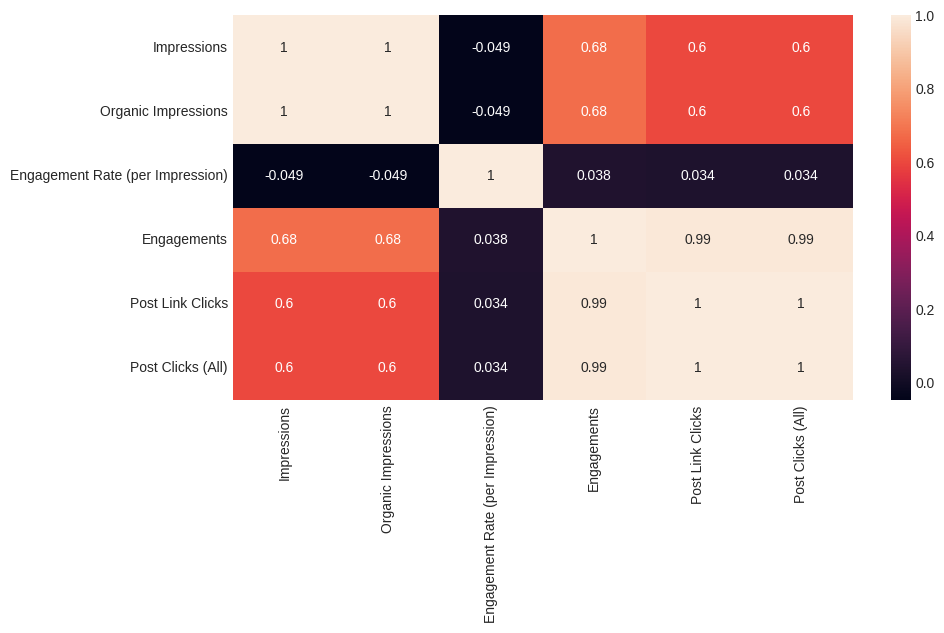

In [47]:
corr_matrix = cleaned_impressions_reach[high_cardinality_columns[3:]]
heatmap(corr_matrix, length=10, width=5)

In [48]:
def time_series_analysis(df, metrics, duration, fill=False, height=600, width=1200):
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    fig = go.Figure()

    for metric in metrics:
        duration_mean = df[metric].resample(duration).mean()
        fig.add_trace(go.Scatter(x=duration_mean.index, y=duration_mean.values, mode='lines', name=metric))
        if fill:
            fig.add_trace(go.Scatter(x=duration_mean.index, y=-duration_mean.values, mode='lines', name=metric, showlegend=False,
                                     fill='tonexty'))

    fig.update_layout(height=height, width=width,
                      title_text='Trend Analysis',
                      xaxis_title='Time',
                      yaxis_title='Value')

    if fill:
      fig.add_shape(
          type="line",
          x0=np.min(df.index),
          y0=0,
          x1=np.max(df.index),
          y1=0,
          line=dict(
              color="LightSeaGreen",
              width=1.0),
          )

    fig.show()


In [51]:
time_series_analysis(cleaned_impressions_reach,
                     impression_reach_cols,
                     duration='Y')

In [52]:
time_series_analysis(cleaned_impressions_reach,
                     impression_reach_cols,
                     duration='M', fill=True)

In [53]:
time_series_analysis(cleaned_impressions_reach,
                     impression_reach_cols,
                     duration='7D', fill=True)

In [54]:
time_series_analysis(cleaned_impressions_reach,
                     ['Engagements'],
                     duration='Y')

In [55]:
time_series_analysis(cleaned_impressions_reach,
                     ['Engagements'],
                     duration='M', fill=True)

In [56]:
time_series_analysis(cleaned_impressions_reach,
                     ['Engagements'],
                     duration='7D', fill=True)

In [57]:
time_series_analysis(cleaned_impressions_reach,
                     click_cols,
                     duration='Y')

In [58]:
time_series_analysis(cleaned_impressions_reach,
                     click_cols,
                     duration='M',fill=True)

In [59]:
time_series_analysis(cleaned_impressions_reach,
                     click_cols,
                     duration='7D',fill=True)

In [60]:
medium_cardinality_columns

['Content Type', 'Sent by']

In [61]:
cleaned_impressions_reach['Content Type'].value_counts()

Photo       5240
Video        849
Text         208
Link          32
Poll           2
Document       1
Name: Content Type, dtype: int64

In [62]:
cleaned_impressions_reach['Sent by'].value_counts()

Blessing Ubah        2348
                     1709
Sophia Amuka         1573
Kemi Amoo             327
Aramide Salami        268
Damilare Oyekanmi      96
Dunni Ogunsanya        11
Name: Sent by, dtype: int64

In [63]:
cleaned_impressions_reach['Sent by'] = np.where(
    cleaned_impressions_reach['Sent by']==' ', cleaned_impressions_reach['Sent by'].replace(
        ' ','Unknown'), cleaned_impressions_reach['Sent by'])

In [64]:
df_grouped = cleaned_impressions_reach.groupby('Sent by')[['Post']].count().sort_values(by=['Post'],ascending=False)
df_grouped

,Post
Sent by,
Blessing Ubah,2348
Unknown,1678
Sophia Amuka,1573
Kemi Amoo,327
Aramide Salami,268
Damilare Oyekanmi,96
Dunni Ogunsanya,11


In [65]:
df_grouped = cleaned_impressions_reach.groupby('Sent by')[engagement_cols].sum().sort_values(by=['Engagements'],ascending=False)
df_grouped

,Engagement Rate (per Impression),Engagements
Sent by,,
Unknown,29635.729458,157817
Sophia Amuka,4662.339069,65736
Blessing Ubah,6725.386508,65604
Aramide Salami,2991.839043,14065
Kemi Amoo,1044.166632,10679
Damilare Oyekanmi,339.302719,5300
Dunni Ogunsanya,22.480652,220


### Numerical Columns

In [66]:
num_cols = list(cleaned_data.select_dtypes(include=['float64']).columns)
num_cols

['Reactions', 'Likes', 'Comments', 'Shares']

In [67]:
cleaned_impressions_reach[num_cols].head(5)

,Reactions,Likes,Comments,Shares
0,3.0,3.0,0.0,0.0
1,1.0,1.0,0.0,0.0
2,11.0,11.0,0.0,0.0
3,0.0,0.0,0.0,0.0
4,9.0,9.0,0.0,1.0


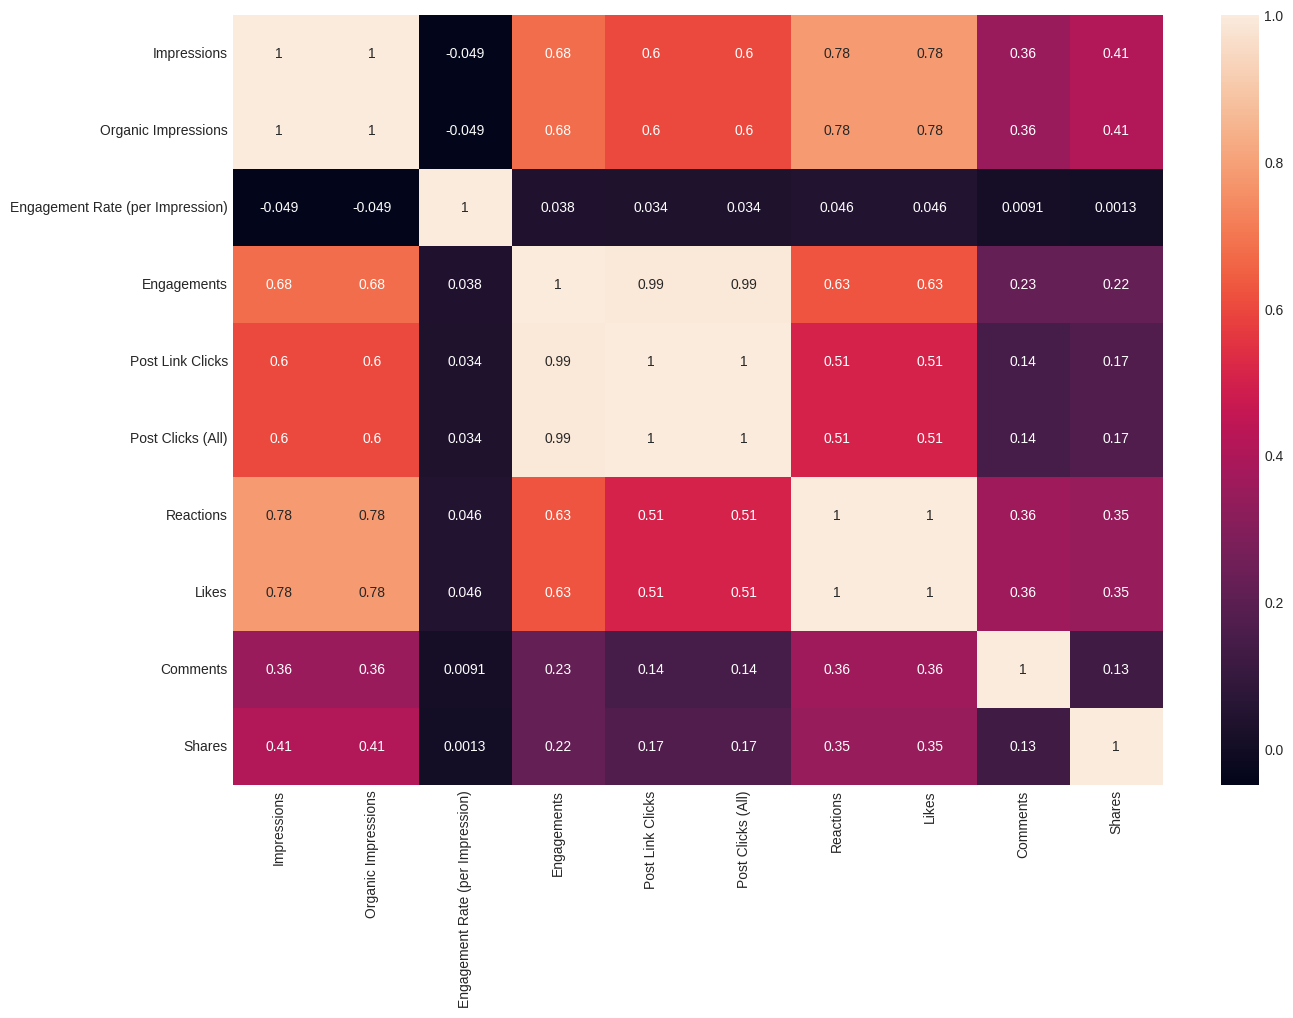

In [68]:
corr_matrix = cleaned_impressions_reach[high_cardinality_columns[3:]+num_cols]
heatmap(corr_matrix, length=15, width=10)

In [69]:
time_series_analysis(cleaned_impressions_reach,
                     num_cols,
                     duration='Y')

In [70]:
time_series_analysis(cleaned_impressions_reach,
                     num_cols,
                     duration='M', fill=True)

In [71]:
time_series_analysis(cleaned_impressions_reach,
                     num_cols,
                     duration='7D', fill=True)

### Posts

In [72]:
data = cleaned_impressions_reach.copy()
data[['Post']].head(5)

,Post
0,Sade was able to acquire a home loan and make ...
1,Safeguard every aspect of your operations with...
2,"Together, we can make a difference and build a..."
3,"Hey CEOs, it’s time to say goodbye to complexi..."
4,With the Stanbic IBTC SME Online-Bento Redirec...


#### Preprocessing

In [73]:
remove_url=lambda x:re.sub(r'http\S+','',str(x))
to_lower=lambda x: x.lower()
remove_puncs= lambda x:x.translate(str.maketrans('','',string.punctuation))

more_words=["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him",
            "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves",
            "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being",
            "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as",
            "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before",
            "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then",
            "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some",
            "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don",
            "should", "now"]

stop_words=set(stopwords.words('english')) #nltk package
stop_words.update(more_words)

remove_words=lambda x: ' '.join([word for word in x.split() if word not in stop_words]) #.join is from package string

def preprocess_text(texts):
  texts = texts.apply(remove_url)
  texts = texts.apply(to_lower)
  texts = texts.apply(remove_puncs)
  texts = texts.apply(remove_words)
  return texts

def clean_text(text):
    '''remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

# function to remove emoticons, symbols or flags by their codes
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


In [74]:
cleaned_posts = preprocess_text(data['Post'])
cleaned_posts = cleaned_posts.apply(lambda x: clean_text(x))
cleaned_posts = cleaned_posts.apply(lambda x: remove_emoji(x))

In [75]:
filtered_data = data.copy()
filtered_data['Post'] = cleaned_posts

,word,frq
0,itcanbe,3522
1,get,1560
2,ibtc,1511
3,stanbic,1503
4,visit,1212


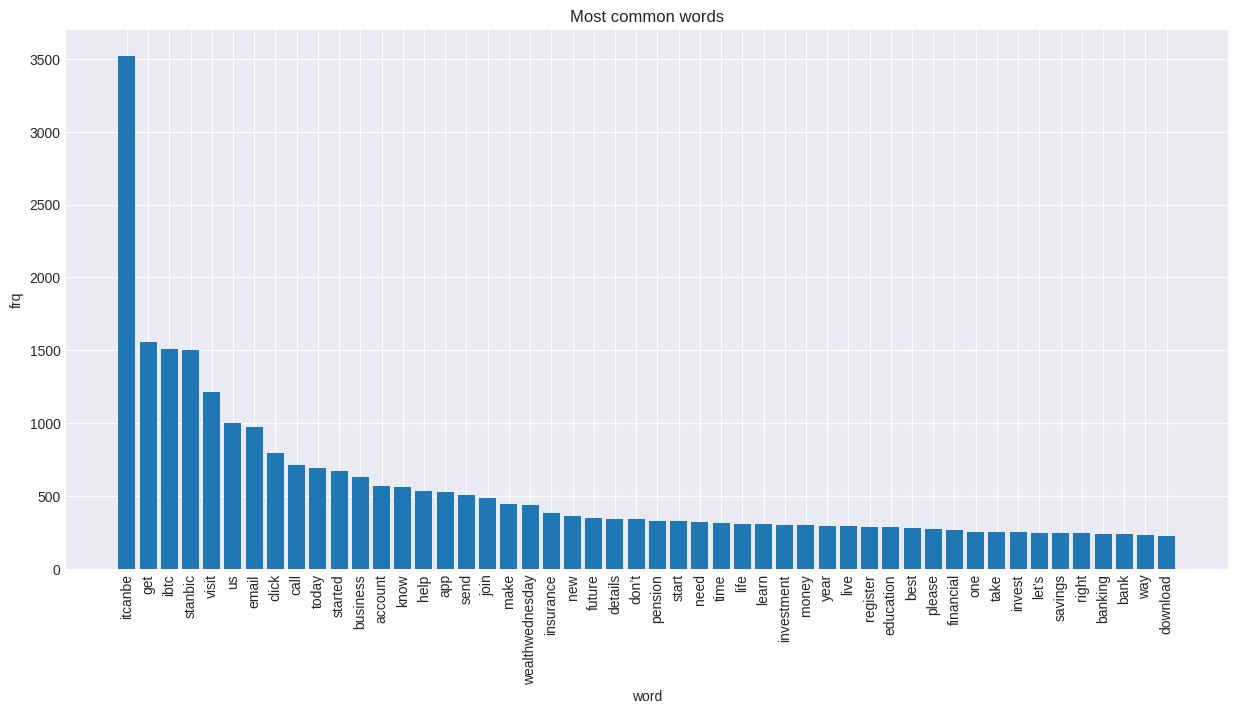

In [76]:
words_list=[word for line in cleaned_posts for word in line.split()]

# creating dataframe and bar graph of most common 50 words with their frequency
word_counts=Counter(words_list).most_common(50)
word_df=pd.DataFrame(word_counts)
word_df.columns=['word','frq']
display(word_df.head(5))

fig = plt.figure(figsize = (15, 7))

# creating the bar plot
plt.bar(word_df['word'],word_df['frq'])
plt.xticks(rotation=90)
plt.xlabel('word')
plt.ylabel('frq')
plt.title('Most common words')
plt.show()

In [77]:
from wordcloud import WordCloud

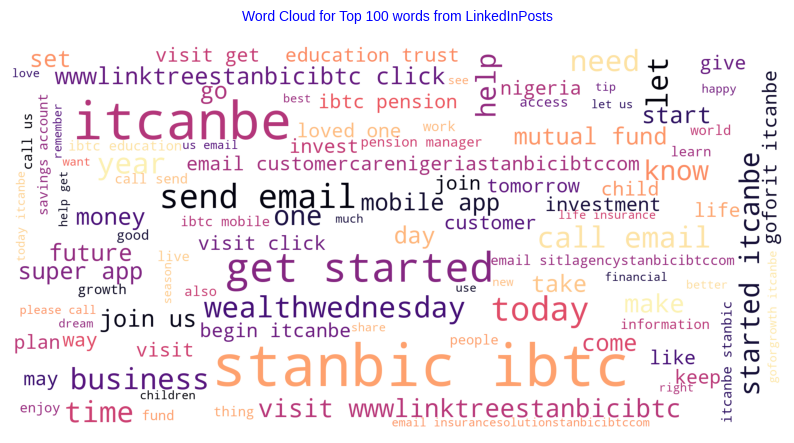

In [91]:
cut_text = " ".join(filtered_data['Post'])
max_words=100
word_cloud = WordCloud(
                    background_color='white',
                    stopwords=set(stop_words),
                    max_words=max_words,
                    max_font_size=30,
                    scale=5,
                    colormap='magma',
                    random_state=1).generate(cut_text)
fig = plt.figure(1, figsize=(10,10))
plt.axis('off')
plt.title('Word Cloud for Top '+str(max_words)+' words from LinkedInPosts\n', fontsize=10,color='blue')
fig.subplots_adjust(top=2.3)
plt.imshow(word_cloud)
plt.show()

#### Annotation/Sentiment Analysis

In [79]:
sid=SentimentIntensityAnalyzer()
ps=lambda x:sid.polarity_scores(x)
sentiment_scores=filtered_data['Post'].apply(ps)

In [80]:
# create the data frame of negative, neutral, positive and compound polarity scores
sentiment_df=pd.DataFrame(data=list(sentiment_scores))
labelize=lambda x:'neutral' if x==0 else('positive' if x>0 else 'negative')
sentiment_df['sentiment_label']=sentiment_df.compound.apply(labelize)

filtered_data = filtered_data.join(sentiment_df['sentiment_label'])

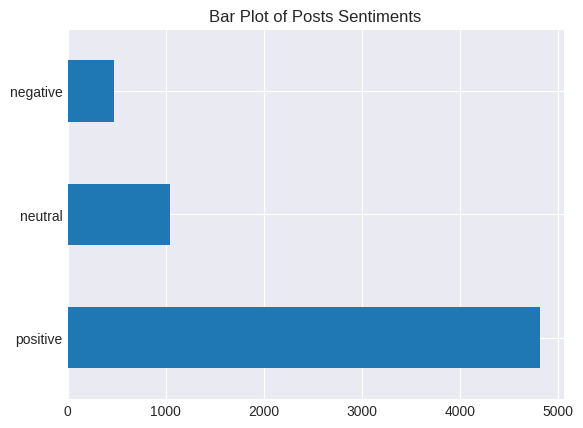

In [81]:
filtered_data['sentiment_label'].value_counts().plot(kind='barh',title="Bar Plot of Posts Sentiments");

In [82]:
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import scipy.stats as stats

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

# spaCy based imports
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
!python -m spacy download en_core_web_lg

2023-10-08 19:59:06.959653: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 1.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [83]:
def topic_modelling(text, n=10):

  cvectorizer = CountVectorizer(max_df=0.95, min_df=2,stop_words='english',decode_error='ignore')
  lda_model = LatentDirichletAllocation(n_components=8,learning_method='online',max_iter=20,random_state=42)
  cvz = cvectorizer.fit_transform(text)
  X_topics = lda_model.fit_transform(cvz)
  n_top_words = n
  topic_summaries = []

  topic_word = lda_model.components_  # get the topic words
  vocab = cvectorizer.get_feature_names_out()

  for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))
    print('Topic {}: {}'.format(i, ' | '.join(topic_words)))

  return cvectorizer, lda_model, topic_summaries

In [84]:
## Get LDA Topics

vectorizer, lda_model, topic_summaries = topic_modelling(filtered_data['Post'], n=15)

Topic 0: join | itcanbe | register | live | happy | day | tomorrow | today | session | click | social | bluetalks | leave | know | walk
Topic 1: itcanbe | ibtc | stanbic | dreams | apply | highlights | conditions | cash | sector | pmi | infrastructure | visit | come | miss | face
Topic 2: itcanbe | visit | insurance | stanbic | click | ibtc | pension | life | today | help | let | started | wealthwednesday | business | email
Topic 3: movingforward | itcanbe | stay | know | bestinsurancedeals | health | online | staysafe | sdg | wealthwednesday | sustainable | safe | goal | development | care
Topic 4: itcanbe | stanbic | ibtc | app | account | email | details | visit | send | download | open | mobile | super | today | started
Topic 5: stanbic | ibtc | itcanbe | business | nigeria | school | growth | africa | bank | trade | watch | goforgrowth | head | capital | banking
Topic 6: itcanbe | email | started | help | let | visit | future | investment | education | send | invest | funds | set 

Based on the topics you've provided, here are 8 unique categories that could be created:

1. **Community Engagement & Events**: This category could include posts about joining events, registering for sessions, and social interactions (Topic 0).
2. **Dream Realization & Financial Services**: This category could cover posts related to realizing dreams, applying for financial services, and sector highlights (Topic 1).
3. **Insurance & Pension Services**: This category could include posts about insurance, pension services, and how to get started with them (Topic 2).
4. **Health & Sustainable Development**: This category could cover posts about health, online safety, and sustainable development goals (Topic 3).
5. **Digital Banking & Account Management**: This category could include posts about digital banking services, account management, and mobile banking apps (Topic 4).
6. **Business Growth & Banking Services**: This category could cover posts about business growth in Nigeria and Africa, banking services, and trade (Topic 5).
7. **Investment & Future Planning**: This category could include posts offering advice on investment, future planning, and education (Topic 6).
8. **Savings & Promotions**: This category could cover posts about savings, seasonal promotions, and winning opportunities (Topic 7).


In [85]:
topic_labels = ['Community Engagement & Events','Dream Realization & Financial Services','Insurance & Pension Services',
                'Health & Sustainable Development:','Digital Banking & Account Management','Business Growth & Banking Services',
                'Investment & Future Planning','Savings & Promotions']

def assign_topic_to_text(text, cvectorizer, lda_model, topic_labels):
    transformed_text = cvectorizer.transform([text])
    topic_distribution = lda_model.transform(transformed_text)
    best_topic = np.argmax(topic_distribution[0])

    return topic_labels[best_topic]

filtered_data['topic_label'] = filtered_data['Post'].apply(
    lambda x: assign_topic_to_text(x, vectorizer, lda_model, topic_labels))

In [86]:
nlp = spacy.load('en_core_web_lg')

In [87]:
def named_entity_recognition(text):
  doc = nlp(text)
  label = [(X.label_) for X in doc.ents]
  return label

def part_of_speech_tagging(text):
  doc = nlp(text)
  label = [(X.pos_) for X in doc]
  return label

filtered_data['ner_label'] = filtered_data['Post'].apply(lambda x:named_entity_recognition(x))
filtered_data['pos_label'] = filtered_data['Post'].apply(lambda x:part_of_speech_tagging(x))

In [88]:
filtered_data['ner_count'] = filtered_data['ner_label'].apply(lambda x:len(x))
filtered_data['pos_count'] = filtered_data['pos_label'].apply(lambda x:len(x))

In [89]:
ner_tags = ['CARDINAL','DATE','GPE','LOC','MONEY','ORDINAL','ORG','PERSON','TIME']
for tag in ner_tags:
  filtered_data[tag + '_count'] = filtered_data['ner_label'].apply(lambda x: x.count(tag))

In [90]:
pos_tags = ['VERB', 'ADV', 'ADJ', 'NUM', 'NOUN', 'SPACE', 'PROPN']
for tag in pos_tags:
    filtered_data[tag + '_count'] = filtered_data['pos_label'].apply(lambda x: x.count(tag))

### Let's Delve in for a Deeper Analysis

Let's see the distribution of Labels

In [92]:
def get_top_n_words(cleaned_posts, ax, n:int=20):
    words_list=[word for line in cleaned_posts for word in line.split()]
    word_counts=Counter(words_list).most_common(n)
    word_df=pd.DataFrame(word_counts)
    word_df.columns=['word','frq']

    ax.bar(word_df['word'],word_df['frq'])
    ax.set_xticklabels(word_df['word'], rotation=90)
    ax.set_xlabel('word')
    ax.set_ylabel('frq')

def word_cloud(texts, ax, n:int=100):
    cut_text = " ".join(texts)
    max_words=n
    word_cloud = WordCloud(
                      background_color='white',
                      stopwords=set(stop_words),
                      max_words=max_words,
                      max_font_size=30,
                      scale=1,
                      colormap='magma',
                      random_state=42).generate(cut_text)
    ax.axis('off')
    ax.imshow(word_cloud)

def sentiment_analyzer(text, ax):
    sid=SentimentIntensityAnalyzer()
    ps=lambda x:sid.polarity_scores(x)
    sentiment_scores=text.apply(ps)

    sentiment_df=pd.DataFrame(data=list(sentiment_scores))
    labelize=lambda x:'neutral' if x==0 else('positive' if x>0 else 'negative')
    sentiment_df['label']=sentiment_df.compound.apply(labelize)

    sentiment_df['label'].value_counts().plot(kind='barh', ax=ax);

In [93]:
def visualize_data(df, column, column_value):
    df_year = df[df[column] == column_value]

    fig, axs = plt.subplots(2, 2, figsize=(15, 10))

    get_top_n_words(df_year['Post'].values, axs[0, 0], n=10)
    axs[0, 0].set_title(f"Top 10 Words in the Top 1% Impression {column_value}")

    word_cloud(df_year['Post'].values, axs[0, 1], n=50)
    axs[0, 1].set_title(f"Word Cloud for Top 50 words in the Top 1% Impression {column_value} period")

    labels = sentiment_analyzer(df_year['Post'], axs[1, 1])
    axs[1, 1].set_title(f"Sentiment Analyzer of Tweets in the Top 1% Impression {column_value} period")

    plt.tight_layout()
    plt.show()

In [94]:
def plot_pos_labels(df, column, pos_tags, rows=2, cols=3, height=750, width=1000, plot=False):
    pos_cols = [f"{pos}_count" for pos in pos_tags]

    if plot == False:
        display(df.groupby(column)[pos_cols+['pos_count']].sum().sort_values(by=['pos_count'],ascending=False))
    else:
        df_grouped = df.groupby(column)[pos_cols].sum()
        specs = [[{'type':'domain'} for _ in range(cols)] for _ in range(rows)]
        axs = [i for i in range(rows * cols)]
        titles = [str(title) for title in df_grouped.index[:len(axs)]]
        fig = make_subplots(rows=rows, cols=cols, subplot_titles=titles, specs=specs)

        for ax, (year, vrow) in zip(axs, df_grouped.iterrows()):
            nrow = ax // cols + 1
            ncol = ax % cols + 1

            fig.add_trace(
                go.Pie(labels=pos_tags, values=vrow.values, name=year),
                row=nrow, col=ncol
            )

        fig.update_layout(height=height, width=width,
                          title_text='POS Tag Distribution',
                          paper_bgcolor='skyblue',
                          plot_bgcolor='skyblue'
                          )

        fig.show()

def plot_ner_labels(df, column, ner_tags, rows=2, cols=3, height=750, width=1000, plot=False):
    ner_cols = [f"{ner}_count" for ner in ner_tags]

    if plot == False:
        display(df.groupby(column)[ner_cols+['ner_count']].sum().sort_values(by=['ner_count'],ascending=False))
    else:
        df_grouped = df.groupby(column)[ner_cols].sum()
        specs = [[{'type':'domain'} for _ in range(cols)] for _ in range(rows)]
        axs = [i for i in range(rows * cols)]
        titles = [str(title) for title in df_grouped.index[:len(axs)]]
        fig = make_subplots(rows=rows, cols=cols, subplot_titles=titles, specs=specs)

        for ax, (year, vrow) in zip(axs, df_grouped.iterrows()):
            nrow = ax // cols + 1
            ncol = ax % cols + 1

            fig.add_trace(
                go.Pie(labels=pos_tags, values=vrow.values, name=year),
                row=nrow, col=ncol
            )

        fig.update_layout(height=height, width=width,
                          title_text='NER Tag Distribution',
                          paper_bgcolor='skyblue',
                          plot_bgcolor='skyblue'
                          )

        fig.show()


In [95]:
def visualize_labels(df, column, column_values, colors, rows=1, cols=3, height=800, width=1200):

  fig = make_subplots(rows, cols, subplot_titles=column_values)

  for i, value in enumerate(column_values):
    nrows = i // cols + 1
    ncols = i % cols + 1

    df_vc = df[df[column]==value]['topic_label'].value_counts()
    fig.add_trace(go.Bar(
        x=df_vc.values, y=df_vc.index, orientation='h', marker_color=colors[i], name=value,
        ),
        row=nrows, col=ncols)
    fig.update_yaxes(showgrid=True,showticklabels=False)

  fig.update_layout(height=height, width=width,legend_title=column,
                    title_text="Distribution Topic Labels",
                    showlegend=False
                    )
  fig.show()


In [96]:
def barplot_labels(data, plotted_cols, colors, rows=2, cols=4, height=800, width=1200):

  subplot_titles = [f'Distribution of Instagram {col} across Topic Labels' for col in plotted_cols]
  fig = make_subplots(rows, cols, subplot_titles=subplot_titles)

  for i, column in enumerate(plotted_cols):
    nrows = i // cols + 1
    ncols = i % cols + 1

    df_yearly = data.groupby(['topic_label'])[column].mean()
    df_yearly = df_yearly.sort_values(ascending=True)
    fig.add_trace(go.Bar(
        x=df_yearly.values, y=df_yearly.index, orientation='h', marker_color=colors[i], name=column,
        ),
        row=nrows, col=ncols)
    fig.update_yaxes(title_text="Topic Label", showgrid=True,showticklabels=False, row=nrows,col=ncols)
    fig.update_xaxes(title_text=column, row=nrows,col=ncols)

  fig.update_layout(height=height, width=width,
                    title_text="Distribution of Instagram Topic Labels",
                    )
  fig.show()

In [97]:
def stack_barchart(data, plot_col, length=15, width=10):

  df = data.groupby([plot_col, 'topic_label'])[['topic_label']].count().rename(columns={'topic_label':'topic_count'})
  df = df.reset_index()

  pivot_df = df.pivot(index='topic_label', columns=plot_col, values='topic_count').fillna(0)

  # Assuming pivot_df is your DataFrame
  fig = go.Figure(data=[
      go.Bar(name=year, x=pivot_df.index, y=pivot_df[year]) for year in pivot_df.columns
  ])
  fig.update_xaxes(title_text='Topic Label')
  fig.update_yaxes(title_text='Frequency')
  # Change the bar mode
  fig.update_layout(barmode='stack', title_text=f'Distribution of Topic Labels Across Each {plot_col}')

  fig.show()


In [98]:
colors = ['skyblue', 'olive', 'gold', 'purple', 'red', 'green', 'orange', 'brown']

#### Distribution of Whole Dataset

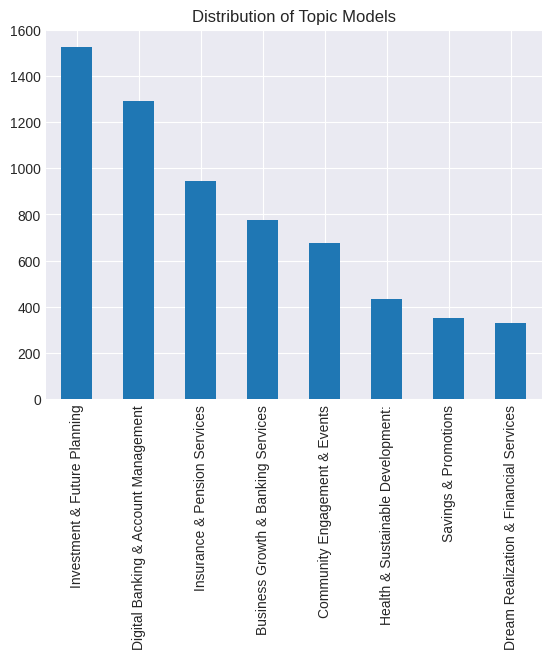

In [99]:
filtered_data['topic_label'].value_counts().plot(kind='bar',title="Distribution of Topic Models");

In [100]:
pos_cols = [f"{pos}_count" for pos in pos_tags]
ner_cols = [f"{ner}_count" for ner in ner_tags]

filtered_data.groupby(['topic_label'])[pos_cols+['pos_count']].mean().sort_values(by=['pos_count'],ascending=False)

,VERB_count,ADV_count,ADJ_count,NUM_count,NOUN_count,SPACE_count,PROPN_count,pos_count
topic_label,,,,,,,,
Business Growth & Banking Services,3.623226,0.353548,2.295484,0.095484,8.033548,0.717419,5.642581,21.637419
Insurance & Pension Services,4.348837,0.400634,1.996829,0.056025,7.248414,0.485201,2.115222,18.455603
Savings & Promotions,3.352273,0.397727,1.980114,0.241477,6.207386,1.886364,2.343750,17.738636
Digital Banking & Account Management,3.696594,0.395511,1.921053,0.099071,6.975232,0.790248,2.291796,17.622291
Health & Sustainable Development:,3.625287,0.514943,2.342529,0.087356,6.873563,0.666667,2.367816,17.604598
Community Engagement & Events,3.762537,0.410029,1.520649,0.067847,5.927729,0.930678,2.510324,16.505900
Investment & Future Planning,3.969160,0.412730,1.664042,0.064304,5.868766,0.488189,1.738189,15.950787
Dream Realization & Financial Services,2.624242,0.266667,1.733333,0.081818,4.839394,0.748485,2.969697,14.030303


In [101]:
filtered_data.groupby(['topic_label'])[ner_cols+['ner_count']].mean().sort_values(by=['ner_count'],ascending=False)

,CARDINAL_count,DATE_count,GPE_count,LOC_count,MONEY_count,ORDINAL_count,ORG_count,PERSON_count,TIME_count,ner_count
topic_label,,,,,,,,,,
Business Growth & Banking Services,0.074839,0.327742,0.397419,0.040000,0.003871,0.025806,0.793548,0.483871,0.023226,2.323871
Savings & Promotions,0.099432,0.622159,0.196023,0.002841,0.025568,0.022727,0.457386,0.184659,0.017045,1.670455
Dream Realization & Financial Services,0.057576,0.412121,0.090909,0.000000,0.006061,0.009091,0.481818,0.375758,0.012121,1.512121
Community Engagement & Events,0.032448,0.480826,0.153392,0.004425,0.001475,0.011799,0.535398,0.209440,0.028024,1.510324
Digital Banking & Account Management,0.077399,0.245356,0.168731,0.003870,0.023220,0.020124,0.511610,0.219814,0.010062,1.320433
Health & Sustainable Development:,0.066667,0.418391,0.089655,0.002299,0.000000,0.020690,0.512644,0.142529,0.011494,1.280460
Insurance & Pension Services,0.044397,0.313953,0.188161,0.000000,0.001057,0.012685,0.483087,0.168076,0.013742,1.255814
Investment & Future Planning,0.049213,0.303150,0.188976,0.001312,0.000656,0.016404,0.469160,0.129265,0.007874,1.182415


In [ ]:
barplot_labels(filtered_data, impression_reach_cols, colors,rows=1,cols=2)

In [ ]:
barplot_labels(filtered_data, engagement_cols, colors,rows=1,cols=2)

In [ ]:
barplot_labels(filtered_data, click_cols, colors,rows=1,cols=2)

In [ ]:
barplot_labels(filtered_data, num_cols, colors,rows=2,cols=2)

In [110]:
stack_barchart(filtered_data, "year")

In [111]:
stack_barchart(filtered_data, "time_period")

In [112]:
stack_barchart(filtered_data, "day_name")

In [113]:
stack_barchart(filtered_data, "day_period")

In [114]:
stack_barchart(filtered_data, "quarter")

In [115]:
wrt = filtered_data[filtered_data['holiday_types']!='Regular Type']
stack_barchart(wrt, "holiday_types")

#### Top 1% Impressions


<ipython-input-92-6c07262c2f5d>:8: UserWarning:

FixedFormatter should only be used together with FixedLocator



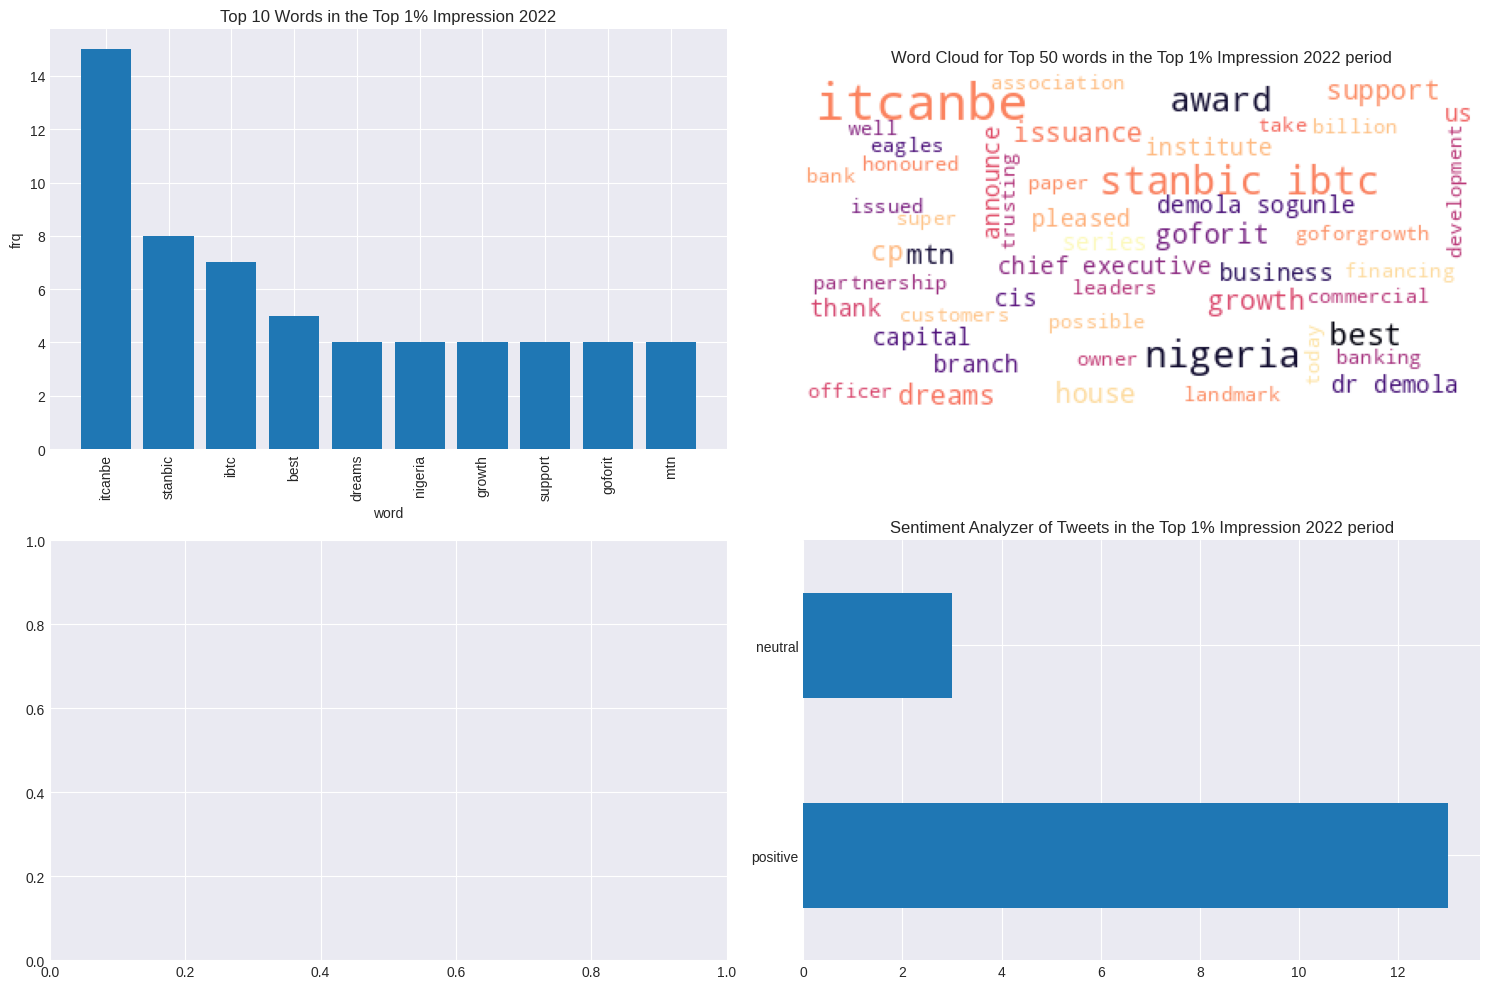

In [119]:
last_quantile = filtered_data['Impressions'].quantile(0.99) #Posts that had Impression in the Top 1%
df = filtered_data[cleaned_impressions_reach['Impressions'] > last_quantile]

visualize_data(df, "year", 2022)

<ipython-input-92-6c07262c2f5d>:8: UserWarning:

FixedFormatter should only be used together with FixedLocator



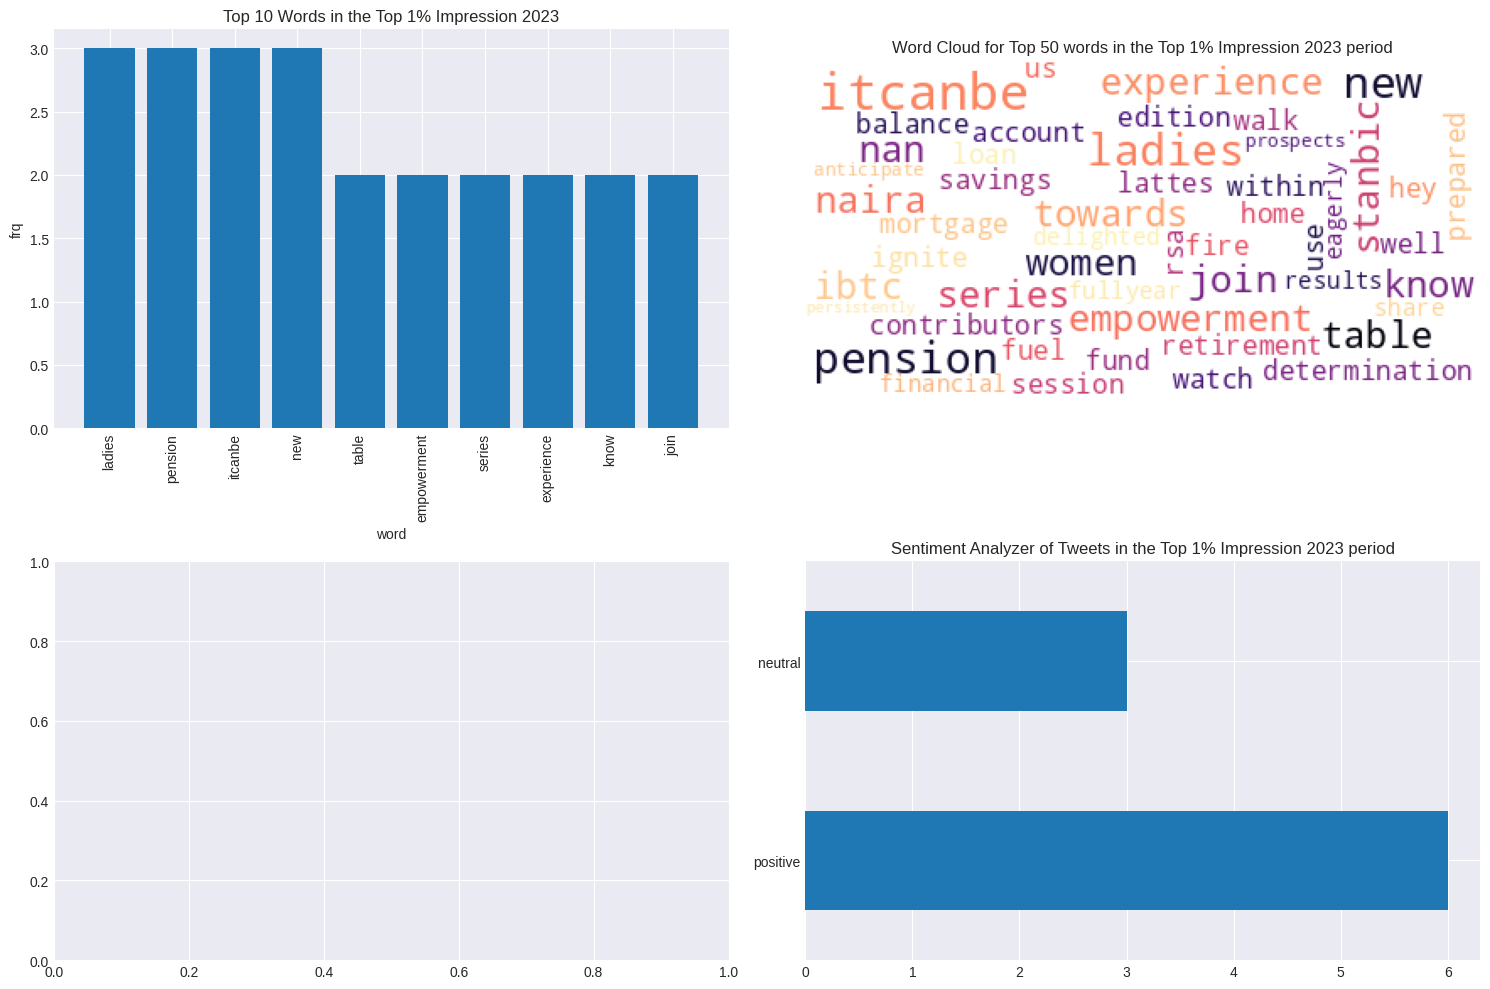

In [120]:
visualize_data(df, "year", 2023)

<ipython-input-92-6c07262c2f5d>:8: UserWarning:

FixedFormatter should only be used together with FixedLocator



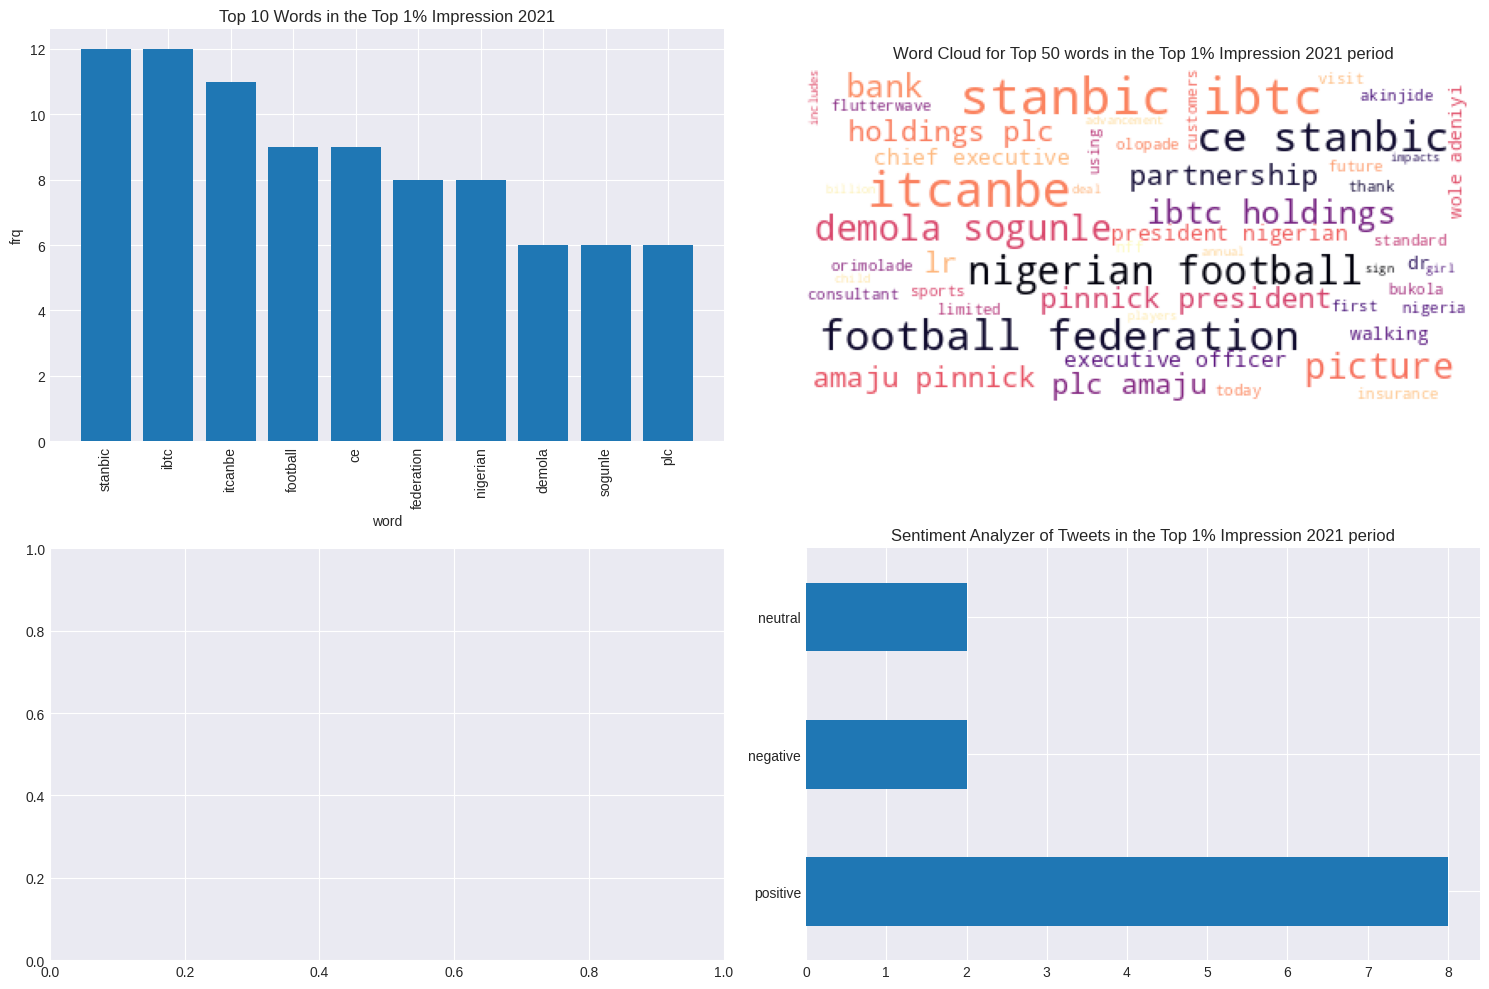

In [121]:
visualize_data(df, "year", 2021)

In [123]:
visualize_labels(df, "year", [2022, 2023, 2021], colors, rows=2, cols=2)

In [124]:
plot_pos_labels(df, "year",  pos_tags, plot=False)

,VERB_count,ADV_count,ADJ_count,NUM_count,NOUN_count,SPACE_count,PROPN_count,pos_count
year,,,,,,,,
2022,57,4,47,3,117,14,111,365
2021,38,3,25,3,84,17,153,334
2020,34,5,35,2,87,10,98,277
2019,35,9,22,0,85,4,72,230
2023,28,5,13,0,59,7,28,151
2018,30,6,16,2,48,1,11,123


In [125]:
plot_ner_labels(df, "year",  ner_tags, plot=False)

,CARDINAL_count,DATE_count,GPE_count,LOC_count,MONEY_count,ORDINAL_count,ORG_count,PERSON_count,TIME_count,ner_count
year,,,,,,,,,,
2021,2,3,8,0,0,4,16,14,0,52
2022,1,3,9,1,1,0,11,13,0,41
2020,0,4,6,0,0,1,14,10,0,35
2019,0,4,4,0,0,0,6,6,0,20
2023,0,1,0,0,0,0,3,3,0,9
2018,1,1,0,0,0,1,1,0,0,5


In [126]:
visualize_labels(df, "time_period", ["Morning", "Afternoon", "Evening"], colors, rows=2, cols=2)

In [127]:
plot_pos_labels(df, "time_period", pos_tags, rows=2, cols=2, plot=False)

,VERB_count,ADV_count,ADJ_count,NUM_count,NOUN_count,SPACE_count,PROPN_count,pos_count
time_period,,,,,,,,
Afternoon,91,10,64,3,195,20,102,506
Night,31,3,35,3,87,11,211,387
Morning,46,7,28,1,108,9,98,310
Evening,54,12,31,3,90,13,62,277


In [128]:
plot_ner_labels(df, "time_period", ner_tags, plot=False)

,CARDINAL_count,DATE_count,GPE_count,LOC_count,MONEY_count,ORDINAL_count,ORG_count,PERSON_count,TIME_count,ner_count
time_period,,,,,,,,,,
Night,0,4,8,0,1,4,17,21,0,59
Afternoon,1,4,11,0,0,0,14,8,0,39
Morning,0,5,4,0,0,1,10,13,0,35
Evening,3,3,4,1,0,1,10,4,0,29


In [129]:
visualize_labels(df, "day_name", ["Thursday", "Wednesday", "Tuesday","Monday"], colors, rows=2, cols=2)

In [130]:
plot_pos_labels(df, "day_name", pos_tags, rows=2, cols=2, plot=False)

,VERB_count,ADV_count,ADJ_count,NUM_count,NOUN_count,SPACE_count,PROPN_count,pos_count
day_name,,,,,,,,
Thursday,58,8,53,1,152,12,271,568
Wednesday,43,9,25,3,83,6,45,225
Monday,33,4,28,0,66,9,59,212
Tuesday,29,4,13,4,62,10,47,175
Friday,25,3,23,1,43,4,24,126
Saturday,26,4,9,0,54,9,18,125
Sunday,8,0,7,1,20,3,9,49


In [131]:
plot_ner_labels(df, "day_name", ner_tags, plot=False)

,CARDINAL_count,DATE_count,GPE_count,LOC_count,MONEY_count,ORDINAL_count,ORG_count,PERSON_count,TIME_count,ner_count
day_name,,,,,,,,,,
Thursday,0,5,9,0,0,4,22,29,0,76
Monday,0,4,2,0,0,0,8,7,0,22
Tuesday,2,1,6,0,1,0,7,3,0,21
Wednesday,1,4,3,1,0,2,4,3,0,19
Saturday,0,1,2,0,0,0,4,3,0,10
Friday,1,0,4,0,0,0,2,1,0,8
Sunday,0,1,1,0,0,0,4,0,0,6


In [133]:
visualize_labels(df, "quarter", ["Q1", "Q4", "Q2"], colors, rows=2, cols=2)

In [134]:
plot_pos_labels(df, "quarter", pos_tags, plot=False)

,VERB_count,ADV_count,ADJ_count,NUM_count,NOUN_count,SPACE_count,PROPN_count,pos_count
quarter,,,,,,,,
Q4,63,8,66,1,172,17,273,610
Q1,53,8,39,3,132,14,63,327
Q2,60,9,28,2,95,15,80,304
Q3,46,7,25,4,81,7,57,239


In [135]:
plot_ner_labels(df, "quarter", ner_tags, plot=False)

,CARDINAL_count,DATE_count,GPE_count,LOC_count,MONEY_count,ORDINAL_count,ORG_count,PERSON_count,TIME_count,ner_count
quarter,,,,,,,,,,
Q4,0,7,13,0,0,4,24,28,0,82
Q1,2,7,5,0,0,0,12,5,0,33
Q2,0,1,4,1,1,0,10,8,0,27
Q3,2,1,5,0,0,2,5,5,0,20


Top 1% Engagements

<ipython-input-92-6c07262c2f5d>:8: UserWarning:

FixedFormatter should only be used together with FixedLocator



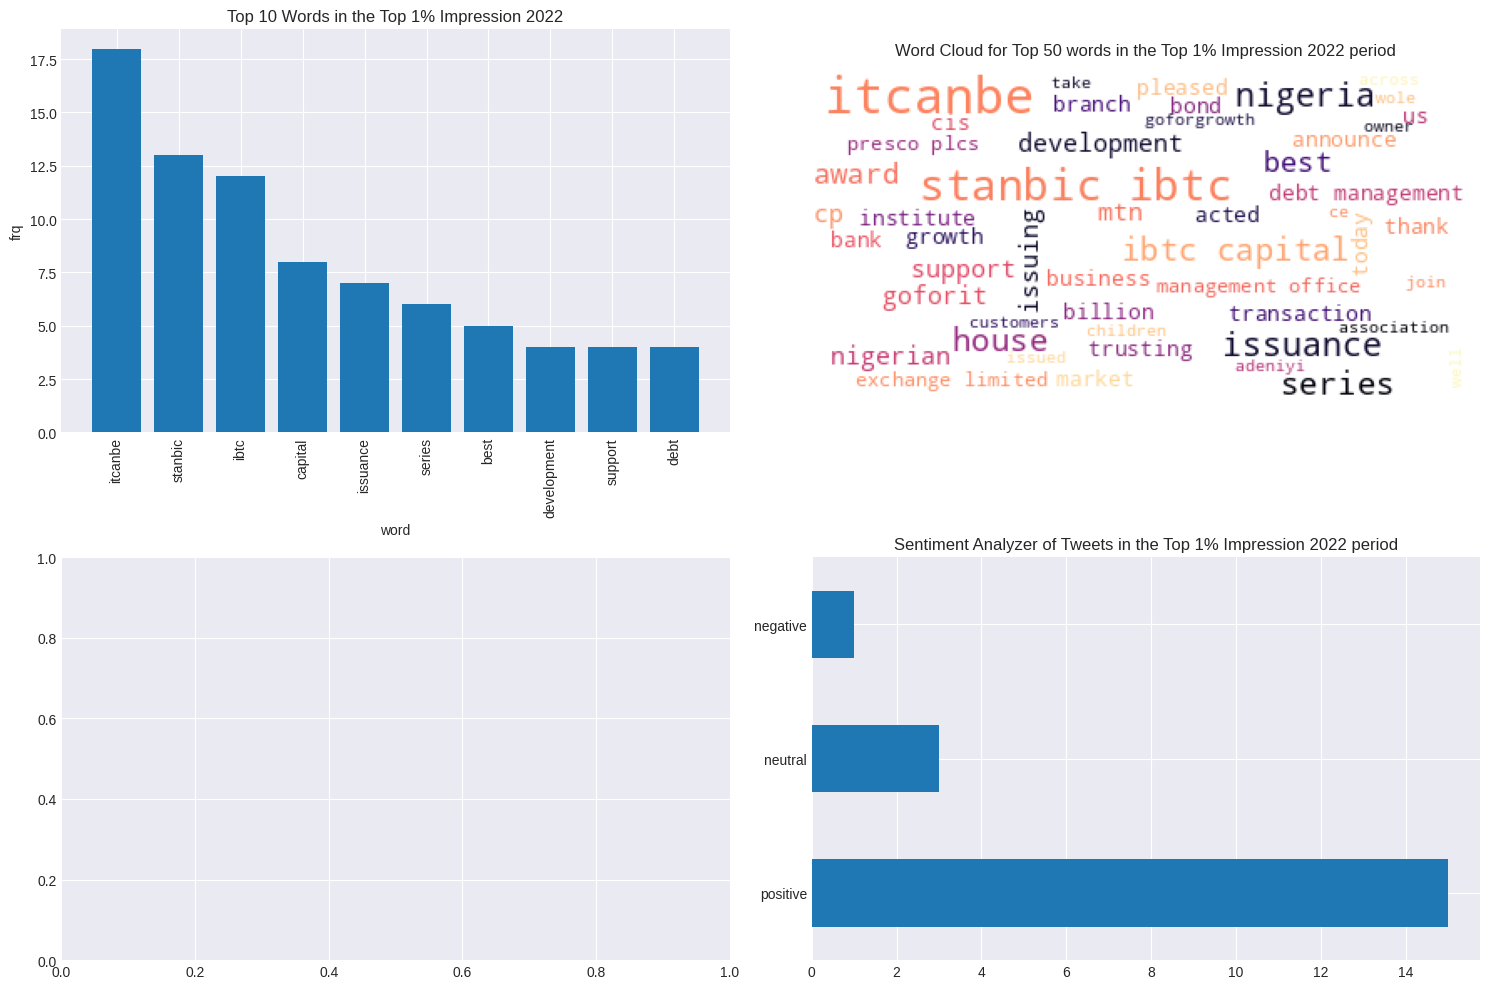

In [136]:
last_quantile = filtered_data['Engagements'].quantile(0.99) #Posts that had Impression in the Top 1%
df = filtered_data[cleaned_impressions_reach['Engagements'] > last_quantile]

visualize_data(df, "year", 2022)

<ipython-input-92-6c07262c2f5d>:8: UserWarning:

FixedFormatter should only be used together with FixedLocator



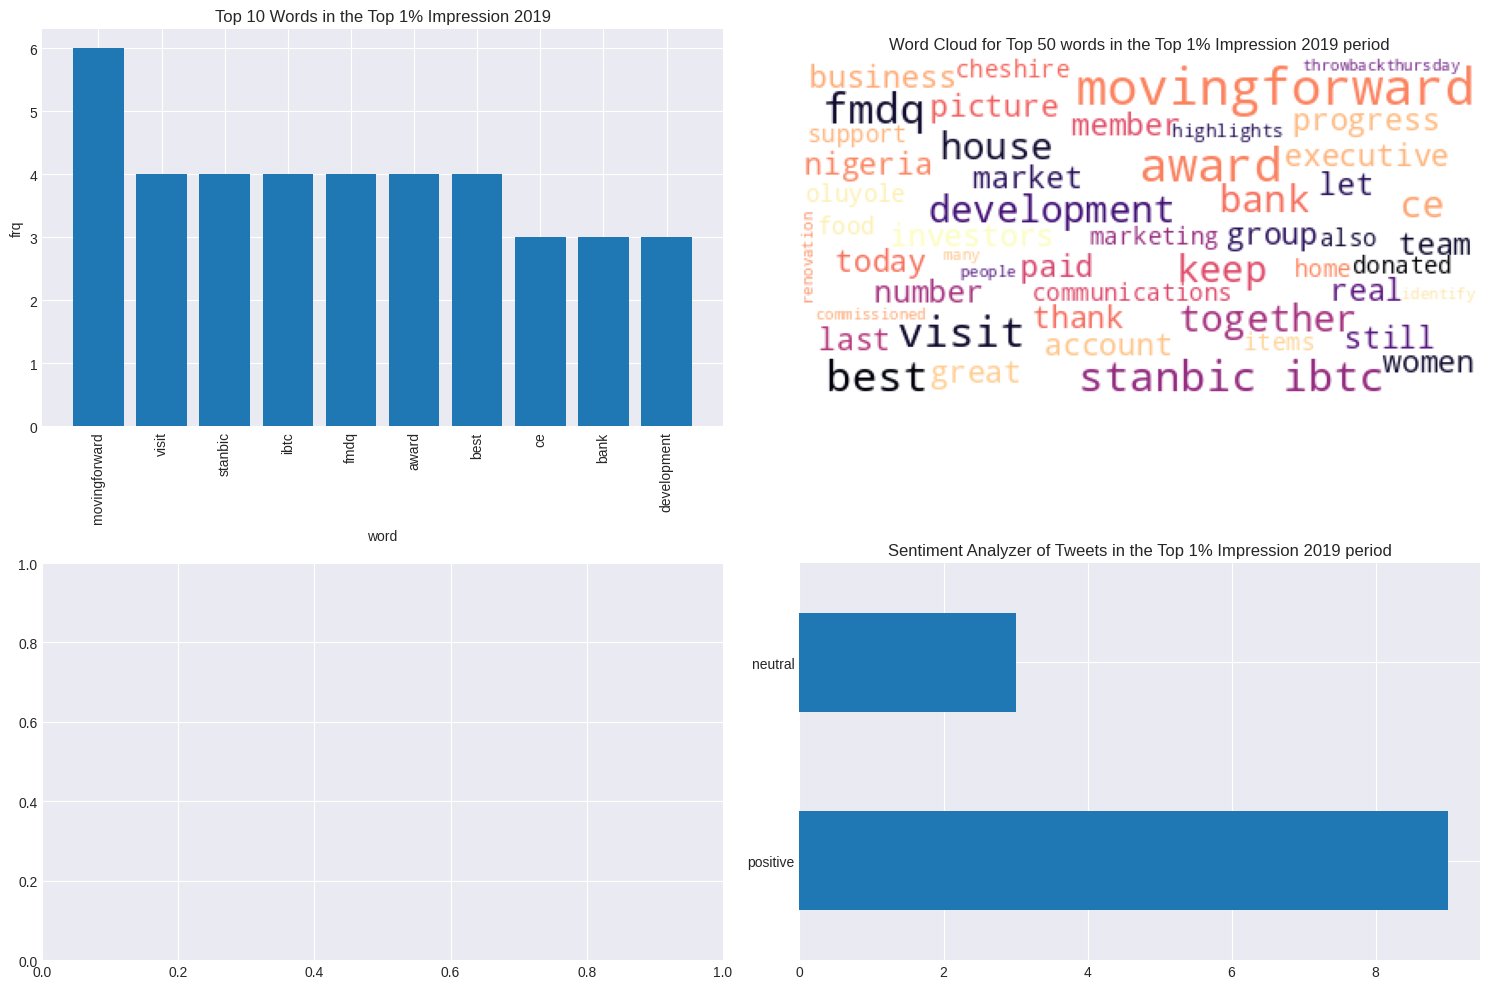

In [137]:
visualize_data(df, "year", 2019)

<ipython-input-92-6c07262c2f5d>:8: UserWarning:

FixedFormatter should only be used together with FixedLocator



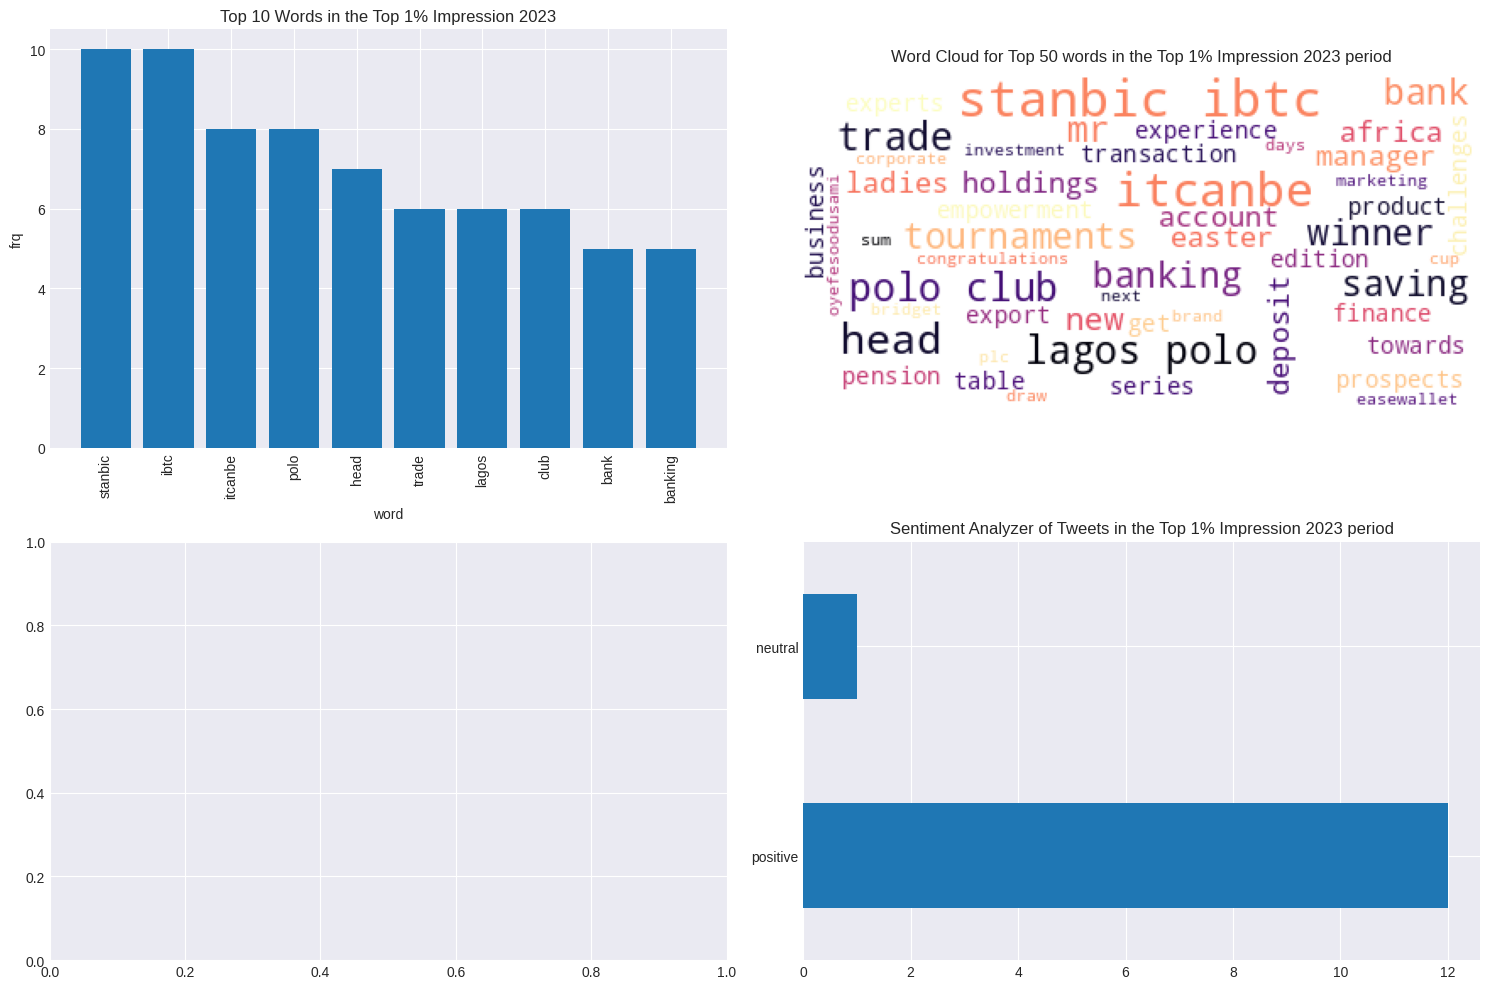

In [138]:
visualize_data(df, "year", 2023)

In [139]:
visualize_labels(df, "year", [2022, 2023, 2019], colors, rows=2, cols=2)

In [140]:
plot_pos_labels(df, "year",  pos_tags, plot=False)

,VERB_count,ADV_count,ADJ_count,NUM_count,NOUN_count,SPACE_count,PROPN_count,pos_count
year,,,,,,,,
2022,84,9,60,5,177,25,145,524
2023,54,5,45,0,161,25,122,425
2021,36,3,21,3,94,17,178,358
2019,41,14,24,1,87,2,62,238
2020,26,3,22,1,51,8,68,186
2018,10,3,9,0,42,1,13,79


In [141]:
plot_ner_labels(df, "year",  ner_tags, plot=False)

,CARDINAL_count,DATE_count,GPE_count,LOC_count,MONEY_count,ORDINAL_count,ORG_count,PERSON_count,TIME_count,ner_count
year,,,,,,,,,,
2022,1,6,9,1,2,1,19,12,0,57
2021,2,5,7,0,0,4,17,17,0,56
2023,0,8,2,0,0,3,16,12,0,43
2020,0,4,4,0,0,1,8,8,0,25
2019,1,5,3,0,0,0,8,3,0,20
2018,0,0,0,0,0,0,4,1,0,7


In [143]:
visualize_labels(df, "time_period", ['Afternoon', 'Evening', 'Morning'], colors, rows=2, cols=2)

In [142]:
visualize_labels(df, "day_name", ["Thursday", "Friday", "Tuesday","Saturday"], colors, rows=2, cols=2)